monai_tester

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import monai
import numpy as np
import nibabel as nib

from pathlib import Path
from modules.monai_dset import get_ds
from modules.model import UNet3dWrapper  

from dotenv import load_dotenv
load_dotenv()
data_dir = os.environ.get('datasets_path')  
local_dataset_path = Path(f'{data_dir}/COVID-19-20_v2') 

In [3]:
trn_ds, val_ds = get_ds(data_folder=str(local_dataset_path/'Train'), width_cri=(192,192,16))

Load and cache transformed data: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


In [4]:
len(trn_ds), len(val_ds)

(9, 2)

In [5]:
trn_ds[0][0]['image'].shape

torch.Size([1, 192, 192, 16])

In [6]:
val_ds[1]['image'].shape

torch.Size([1, 304, 304, 71])

In [7]:
trn_loader = monai.data.DataLoader(trn_ds, batch_size=2, num_workers=4, pin_memory=True)
val_loader = monai.data.DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=True)

In [ ]:
slice_idx * (ct.hu.shape[0] - 1) // 5 

In [21]:
val_ct = val_loader.dataset[8]['image']

In [24]:
val_ct.shape

torch.Size([1, 397, 397, 73])

In [23]:
val_ct.shape[-1] // 5 

14

In [13]:
trn_loader.dataset[8][1]

{'image': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0

In [10]:
for batch in trn_loader:
    print(batch['image'].shape)
    print(batch['image'].transpose(2,-1).shape)
    print(batch['image'].max(), batch['image'].min())
    break

torch.Size([4, 1, 192, 192, 16])
torch.Size([4, 1, 16, 192, 192])
tensor(1.) tensor(0.)


In [26]:
for batch in val_loader:
    print(batch['image'].shape)
    break

torch.Size([1, 1, 352, 352, 60])


In [3]:
seg_model = UNet3dWrapper(
    in_channels=1,
    n_classes=1,
    depth=3,
    wf=4,
    padding=True,
    pad_type='reflect',
    batch_norm=True,
    up_mode='upconv').cuda()

In [4]:
def get_inferer(_mode=None):
    """returns a sliding window inference instance."""

    patch_size = (192, 192, 16)
    sw_batch_size, overlap = 2, 0.5
    inferer = monai.inferers.SlidingWindowInferer(
        roi_size=patch_size,
        sw_batch_size=sw_batch_size,
        overlap=overlap,
        mode="gaussian",
        padding_mode="reflect",
    )
    return inferer

In [57]:
max_epochs, lr, momentum = 500, 1e-4, 0.95
opt = torch.optim.Adam(seg_model.parameters(), lr=lr)

In [76]:
seg_model.eval()
for batch in trn_loader:
    img, label = batch['image'], batch['label']
    img_g = img.cuda()
    x = seg_model(img_g)
    print(x.shape)
    break

torch.Size([6, 1, 192, 192, 16])


In [31]:
torch.cuda.empty_cache()

In [27]:
from monai.inferers import SlidingWindowInferer

class ToyModel:
    # A simple model generates the output by adding an integer `pred` to input.
    # each call of this instance increases the integer by 1.
    pred = 0
    def __call__(self, input):
        self.pred = self.pred + 1
        input = input + self.pred
        return input

infer1 = SlidingWindowInferer(roi_size=(40, 40), sw_batch_size=1, overlap=0)
infer2 = SlidingWindowInferer(roi_size=(40, 40), sw_batch_size=2, overlap=0)
infer3 = SlidingWindowInferer(roi_size=(40, 40), sw_batch_size=10, overlap=0)
input_tensor = torch.zeros(1, 1, 200, 200)
# output_tensor = infer(input_tensor, seg_model)
output_tensor_1 = infer1(input_tensor, ToyModel())
output_tensor_2 = infer2(input_tensor, ToyModel())
output_tensor_3 = infer3(input_tensor, ToyModel())

In [11]:
import matplotlib.pyplot as plt

In [28]:
# output_t = output_tensor.cpu().detach()
output_1 = output_tensor_1

In [29]:
output_t.shape

torch.Size([1, 1, 200, 200])

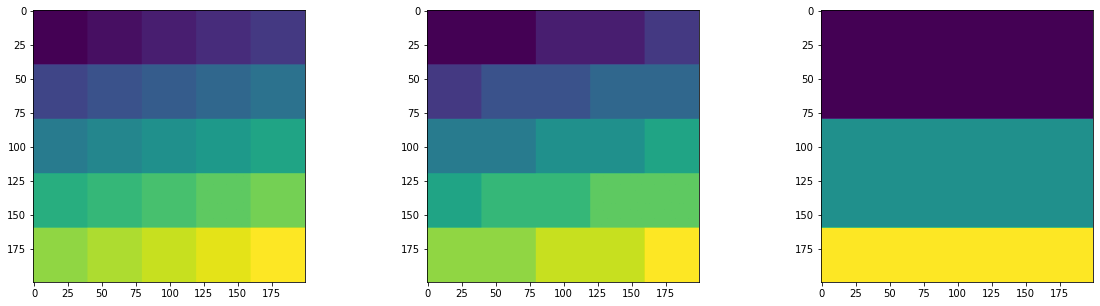

In [30]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].imshow(output_tensor_1[0, 0,:,:])
ax[1].imshow(output_tensor_2[0, 0,:,:])
ax[2].imshow(output_tensor_3[0, 0,:,:])

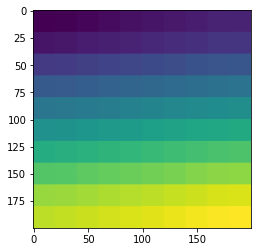

In [82]:
plt.imshow(output_tensor[0, 0]); plt.show()